In [ ]:
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.models as models  # importing torchvision.models for ResNet
import os

# Define RMSE Loss function
def rmse_loss(y_true, y_pred):
    return torch.sqrt(torch.mean((y_pred - y_true) ** 2))

# Get the current working directory
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

# Update the file path to include the current directory or correct path
file_path = os.path.join(current_directory, 'new_dataset.hdf5')

# Load dataset from the HDF5 file
with h5py.File(file_path, 'r') as f:
    # Assuming the dataset has 'images' and 'redshifts' datasets
    X = f['images'][:]   # Assuming the key for the images is 'images'
    y = f['specz_redshift'][:]  # Assuming the key for the redshift values is 'redshifts'
X = X[:, 2, :, :]
X = X[:, None, :, :]
# Check the shape of the data before reshaping
print(f"Original shape of images: {X.shape}")

# You can reshape the data only after knowing the shape
# Assuming X is shaped like (N, H, W) or (N, H, W, C)


# Check the new shape of the data
print(f"Reshaped images to: {X.shape}")
print(f"Loaded redshifts with shape: {y.shape}")

# Convert the images and labels to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)  # No need to unsqueeze if already (N, C, H, W)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Reshape labels to (N, 1) for regression

# Split the dataset into training, validation, and test sets
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.6 * len(dataset))  # 60% for training
val_size = int(0.2 * len(dataset))    # 20% for validation
test_size = len(dataset) - train_size - val_size  # Rest for test

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Load ResNet18 model from torchvision
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)  # Change input channels to 1
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Modify for regression with 1 output neuron


Current working directory: /content
Original shape of images: (3000, 1, 107, 107)
Reshaped images to: (3000, 1, 107, 107)
Loaded redshifts with shape: (3000,)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


In [ ]:
import torch
import torch.optim as optim
tensor = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
# Assuming you already have your model, loss function, and device defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to the device (GPU/CPU)

# Define optimizer and loss function (assuming loss_fn is already defined)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed
loss_fn = torch.nn.MSELoss()  # Example: MSE Loss for regression tasks

epochs = 10  # Adjust as needed

# Training loop
for epoch in range(epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # Reset gradients
        output = model(data)  # Forward pass
        loss = loss_fn(output, target)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    with torch.no_grad():  # No gradient calculation during evaluation
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)  # Move data to the same device
            output = model(data)
            val_loss += loss_fn(output, target).item()  # Sum up batch loss
    val_loss /= len(val_loader)  # Average validation loss
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")

# Testing loop
model.eval()  # Set model to evaluation mode
test_loss = 0
with torch.no_grad():  # No gradient calculation during testing
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)  # Move data to the same device
        output = model(data)
        test_loss += loss_fn(output, target).item()  # Sum up batch loss
test_loss /= len(test_loader)  # Average test loss
print(f"Test Loss: {test_loss:.4f}")


Epoch 1/10, Validation Loss: 0.0315
Epoch 2/10, Validation Loss: 0.1813
Epoch 3/10, Validation Loss: 0.2857
Epoch 4/10, Validation Loss: 0.2773
Epoch 5/10, Validation Loss: 0.0738
Epoch 6/10, Validation Loss: 0.0056
Epoch 7/10, Validation Loss: 0.0071
Epoch 8/10, Validation Loss: 0.0052
Epoch 9/10, Validation Loss: 0.0044
Epoch 10/10, Validation Loss: 0.0042
Test Loss: 0.0043


In [ ]:
import h5py
import torch

# Assuming your model, device, and necessary libraries are already imported
# Load the model if it's not already loaded
# model = torch.load('path_to_your_trained_model.pth')
model.eval()  # Set the model to evaluation mode

# Define the path to your HDF5 dataset
file_path = 'new_dataset.hdf5'

# Load the dataset
with h5py.File(file_path, 'r') as f:
    # Assuming the dataset has 'images' and 'specz_redshift' datasets
    X = f['images'][:]  # Load the images
    y = f['specz_redshift'][:]  # Load the redshifts

# Select an index for the image you want to test (change index as needed)
index = 0  # Example: index of the image to test
input_image = X[0, 2, :, :]  # Extract the 3rd channel of the image

# Preprocess the input image
input_image = input_image[None, None, :, :]  # Reshape to (1, 1, 107, 107) for the model
input_tensor = torch.tensor(input_image, dtype=torch.float32).to(device)  # Convert to tensor and send to device

# Make prediction
with torch.no_grad():  # Disable gradient calculation
    output = model(input_tensor)  # Get the model's output

# Convert output to redshift
predicted_redshift = output.item()  # Get the predicted value as a scalar

# Output the predicted redshift
print(f"Predicted Redshift: {predicted_redshift:.4f}")


Predicted Redshift: 0.0865


Mean Absolute Error (MAE): 0.0585
Mean Squared Error (MSE): 0.0053
Root Mean Squared Error (RMSE): 0.0730


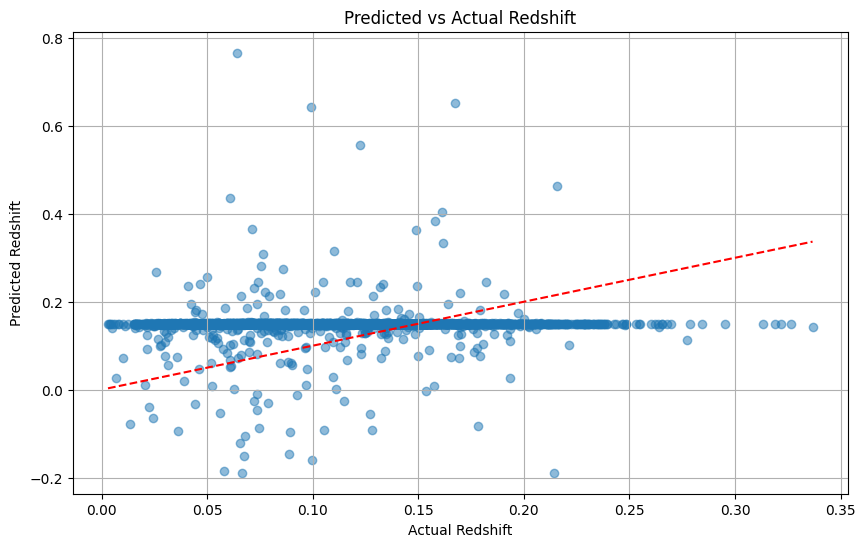

In [ ]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
file_path = 'new_dataset.hdf5'
with h5py.File(file_path, 'r') as f:
    X = f['images'][:]   # Load the images
    y = f['specz_redshift'][:]  # Load the redshifts

# Extract the 3rd channel (index 2) for the evaluation
X = X[:, 2, :, :]  # Select 3rd band
X = X[:, None, :, :]  # Reshape to (N, 1, 107, 107)

# Convert to PyTorch tensors and send to device
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)  # Reshape for regression

# Make predictions on the entire dataset (or you can use a validation/test set)
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    predictions = model(X_tensor)  # Get model predictions

# Convert predictions to numpy for easier manipulation
predictions = predictions.cpu().numpy()  # Move to CPU and convert to numpy
y_actual = y_tensor.cpu().numpy()  # Move to CPU and convert to numpy

# Calculate evaluation metrics
mae = mean_absolute_error(y_actual, predictions)
mse = mean_squared_error(y_actual, predictions)
rmse = np.sqrt(mse)

# Print the error metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Visualization: Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_actual, predictions, alpha=0.5)
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')  # Diagonal line
plt.xlabel('Actual Redshift')
plt.ylabel('Predicted Redshift')
plt.title('Predicted vs Actual Redshift')
plt.grid()
plt.show()
